# Ćwiczenie 2 - otoczka wypukła

## Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

## Interfejsy

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()


In [3]:
class Scan_visualiser:
    def make_LinesCollection(points):
        res = []
        for i in range(1,len(points)):
            res.append([points[i-1], points[i]])
        return res
    
    def __init__(self):
        self.scenes = []
    def put_scene(self, s):
        self.scenes.append(s)
    def get_scenes(self):
        return self.scenes
    
    def put_scene_scan(self, p, l, a=[]):
        self.put_scene(Scene( [ PointsCollection(p,color='yellow'),PointsCollection(l,color = 'blue'), PointsCollection(a,color='red')], 
                              [ LinesCollection(Scan_visualiser.make_LinesCollection(l),color='blue')]))

In [4]:
def print_to_file(points, name):
    file = open(name+".txt","w") 
    
    for i in points: 
        file.write(str(i)+'\n') 
 
    file.close()

## Generowanie zbiorów punktów

In [5]:
import random
random.seed(200)

### Zbiór A

In [6]:
def randomPoints(start, stop, n):
    arr = [[0,0] for i in range(n)]
    p = stop - start
    for i in range(n):
        arr[i][0]=random.random()*p+start+random.random()
        arr[i][1]=random.random()*p+start+random.random()
    return arr

### Zbiór B

In [7]:
from math import pi,cos,sin
def randomPointsCircle(R,n,middle):
    arr = [[0,0] for i in range(n)]
    for i in range(n):
        a = random.random()*2*pi
        arr[i][0]=R*cos(a)+middle[0]
        arr[i][1]=R*sin(a)+middle[1]
    return arr

### Zbiór C

In [8]:
def randomPointsRectangle(a1,a2,b1,b2,n):
    arr = [[0,0] for i in range(n)]
    for i in range(0,n,2):
        px = a2[0] - a1[0]
        x = random.random()*px + a1[0]
        if (int(random.random()*10))%2==0:
            y = a1[1]
        else:
            y = b1[1]
        
        arr[i][0]=x
        arr[i][1]=y
        
        py = b1[1] - a1[1]
        y = random.random()*py + a1[1]

        if (int(random.random()*10))%2==0:
            x = a1[0]
        else:
            x = a2[0]
            
            
        arr[i+1][0]=x
        arr[i+1][1]=y
        
        
    return arr
    

### Zbiór D

In [9]:
from math import tan
def randomPointsSquare(a1,a2,a3,a4,n_a, n_d):
    
    arr = [[0,0] for i in range(2*n_a+2*n_d+4)]
    # bok (a1,a3)
    for i in range(n_a):
        x = a1[0]
        py = a3[1]-a1[1]
        y = random.random()*py+a1[1]
        arr[i][0]=x
        arr[i][1]=y
    
    # bok (a1,a2)
    for i in range(n_a, 2*n_a):
        y = a2[1]
        px = a2[0]-a1[0]
        x = random.random()*px+a1[0]
        arr[i][0]=x
        arr[i][1]=y
        
    # przekątna (a1,a4)
    # y = ax + b
    b = a1[1]
    a = 1
    
    for i in range(2*n_a, 2*n_a+n_d):
        px = a2[0]-a1[0]
        x = random.random()*px + a1[0]
        y = a*x + b
        arr[i][0]=x
        arr[i][1]=y
    
    # przekątna (a3,a2)
    b = a3[1]
    a = -1
    for i in range(2*n_a+n_d, 2*n_a+2*n_d):
        px = a2[0]-a1[0]
        x = random.random()*px + a1[0]
        y = a*x + b
        arr[i][0]=x
        arr[i][1]=y
    
    arr[-1][0]= a1[0]
    arr[-1][1]= a1[1]
    arr[-2][0]= a2[0]
    arr[-2][1]= a2[1]
    arr[-3][0]= a3[0]
    arr[-3][1]= a3[1]
    arr[-4][0]= a4[0]
    arr[-4][1]= a4[1]
    
    
    return arr
    
    

## Wizualizacja graficzna punktów

In [10]:
points = randomPoints(-100,100,100)

<IPython.core.display.Javascript object>


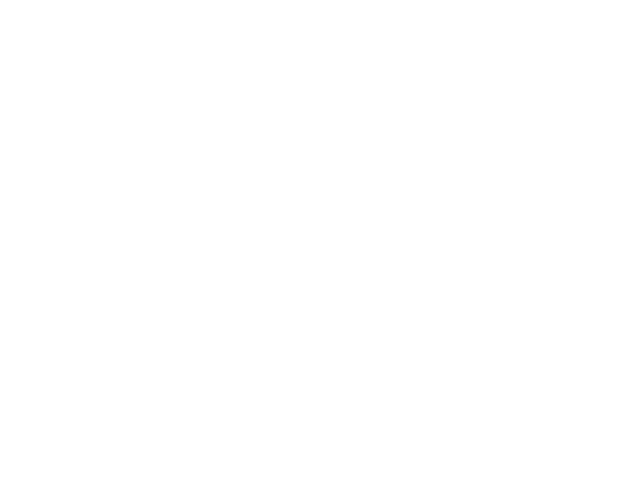

In [11]:
%matplotlib notebook
visualiser = Scan_visualiser()
visualiser.put_scene(Scene([PointsCollection(points,color='green')]))
scenes = visualiser.scenes
plot = Plot(scenes)
plot.draw()

In [12]:
circle = randomPointsCircle(10,100,(0,0))

<IPython.core.display.Javascript object>


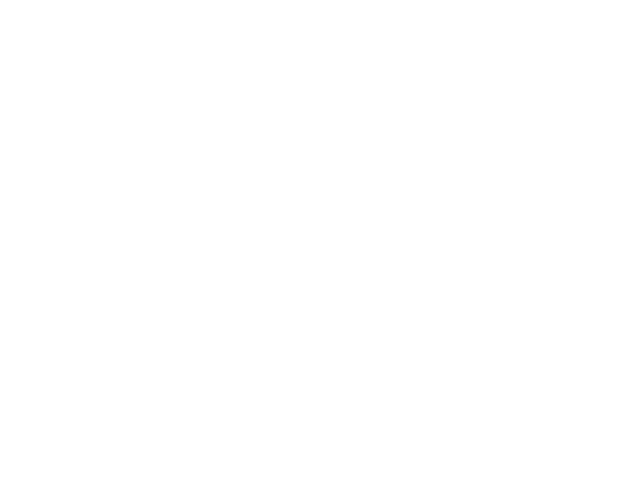

In [13]:
%matplotlib notebook
visualiser = Scan_visualiser()
visualiser.put_scene(Scene([PointsCollection(circle,color='green')]))
scenes = visualiser.scenes
plot = Plot(scenes)
plot.draw()

In [14]:
rectangle = randomPointsRectangle((-10,-10),(10,-10),(-10,10),(10,10),100)

<IPython.core.display.Javascript object>


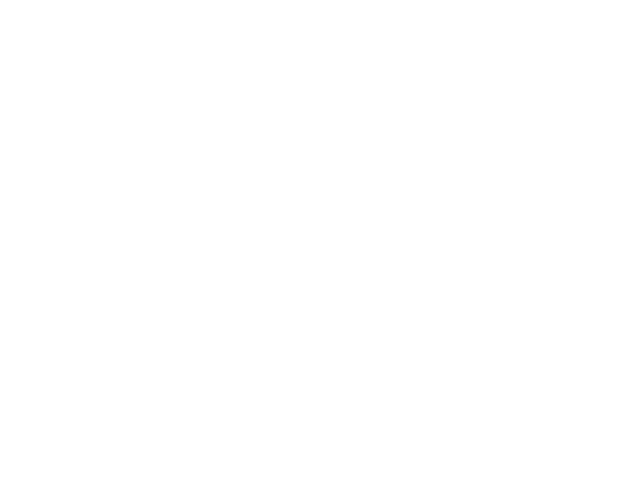

In [15]:
%matplotlib notebook
visualiser = Scan_visualiser()
visualiser.put_scene(Scene([PointsCollection(rectangle,color='green')]))
scenes = visualiser.scenes
plot = Plot(scenes)
plot.draw()

In [16]:
square = randomPointsSquare((0,0),(10,0),(0,10),(10,10),25,20)

<IPython.core.display.Javascript object>


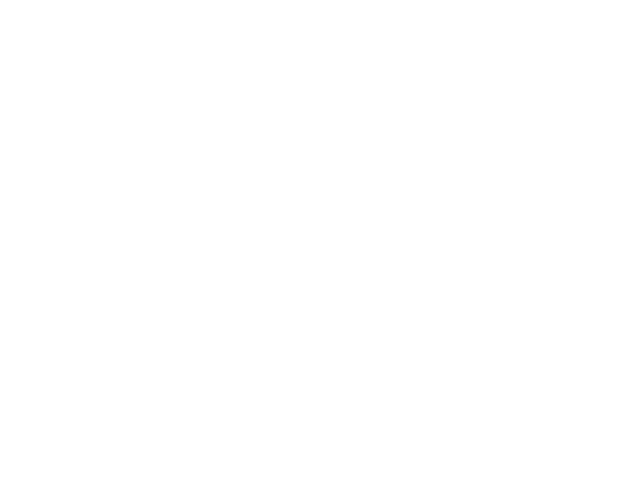

In [17]:
%matplotlib notebook
visualiser = Scan_visualiser()
visualiser.put_scene(Scene([PointsCollection(square,color='green')]))
scenes = visualiser.scenes
plot = Plot(scenes)
plot.draw()

## Algorytm Grahama

In [18]:
import math
eps = 10**(-12)


def det(p1, p2, p3):
    d = (p2[0] - p1[0])*(p3[1] - p1[1]) - (p2[1] - p1[1])*(p3[0] - p1[0])
    if abs(d)<eps:
        return 0
    else: 
        return d

    
def sort_by_angle(p,k,mi,A):
    
    
    def partition(left,right,mi,A):
        i=left-1
        pivot=slope(mi,A[right])
        for j in range(left,right):
            if slope(mi, A[j])<=pivot:
                i+=1
                A[i],A[j]=A[j],A[i]
        A[i+1],A[right]=A[right],A[i+1]
        return i+1


    if p<k:
        pi=partition(p,k,mi,A)
        sort_by_angle(p,pi-1,mi,A)
        sort_by_angle(pi+1,k,mi, A)
    

def distance(p1,p2):
    return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def remove_collinear(s,A):
    start = s 
    prev = A[0]
    result = []
    result.append(A[0])
    for i in range(1,len(A)):
        if det(s, prev, A[i])==0 and distance(s,prev)<distance(s,A[i]):
            pass
        else:
            start = prev
            prev = A[i]
            result.append(A[i])
    return result
    
    
# obliczam kąt pomiędzy punktami    
def angle(p1, p2):
    # zwraca nieskończoność, ponieważ dzielenie przez zero, jako że zaczynam od punktu wysuniętego najbardziej 
    # wysuniętego w lewo to to jest maksymalny kąt jaki można uzyskać
    if p1[0]==p2[0]:
        return float('inf')
    # zraca nachylenie
    return 1.0*(p1[1]-p2[1])/(p1[0]-p2[0])



def graham(points, visualiser):
    p = points
    visualiser.put_scene(Scene([PointsCollection(p,color='yellow')]))
        
    start = min(p, key=lambda p: (p[0], p[1]))
    s = points.pop(p.index(start))
    
    # w pierwszej kolejności sortuję po kącie, jeśli są równe to porównuję ich współrzędne x
    p.sort(key=lambda p: (angle(p,start), p[0]))
    
    #p = remove_collinear(s,p)
    
    ans1 = []
    ans1.append([s[0],s[1]])
    
    visualiser.put_scene_scan(p,ans1)
    for (x,y) in p:
        ans1.append([x,y])
        while len(ans1) > 2 and det(ans1[-3], ans1[-2], ans1[-1]) <= 0:
            ans1.pop(-2)
            if len(ans1) > 3:
                visualiser.put_scene_scan(p, ans1,[ans1[-3],ans1[-2],ans1[-1]])
            
                
    ans1.append(s)
    visualiser.put_scene_scan(p, ans1)
    return ans1


## Wyniki dla algortymu Grahama

### Zbiór A

In [32]:
%matplotlib notebook
random.seed(200)
points = randomPoints(-100,100,100)
visualiser = Scan_visualiser()
ans = graham(points, visualiser)
scenes = visualiser.scenes
plot = Plot(scenes)
plot.draw()

# zapisywanie punktów otoczki do pliku o nazwie "plik"
print_to_file(ans, "plik")

<IPython.core.display.Javascript object>

### Zbiór B

<IPython.core.display.Javascript object>


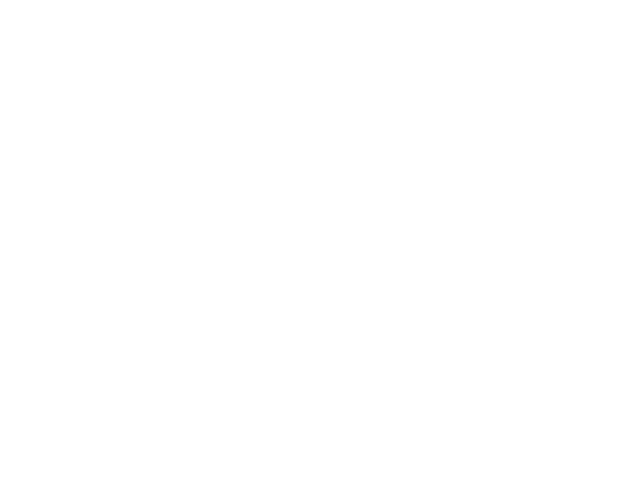

In [20]:
%matplotlib notebook
visualiser = Scan_visualiser()
graham(circle, visualiser)
scenes = visualiser.scenes
plot = Plot(scenes)
plot.draw()

### Zbiór C

<IPython.core.display.Javascript object>


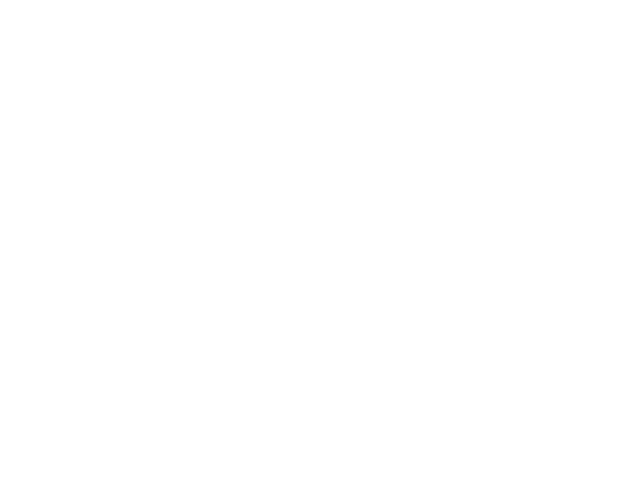

In [21]:
%matplotlib notebook
visualiser = Scan_visualiser()
graham(rectangle, visualiser)
scenes = visualiser.scenes
plot = Plot(scenes)
plot.draw()

### Zbiór D

In [33]:
%matplotlib notebook
visualiser = Scan_visualiser()
square = randomPointsSquare((0,0),(10,0),(0,10),(10,10),25,20)
graham(square, visualiser)
scenes = visualiser.scenes
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>

## Algorytm Jarvisa

In [23]:
def min_angle(p, s, n, used):
    if s!=p[0] and 0 not in used:
        q=0
    else:
        q=1
     # q - indeks aktualnego minimum

    for i in range(n):
        if i!=q and i not in used:
            if p[i]!=s and det(s,p[i],p[q])<0: 
                q = i
            elif det(s,p[i],p[q])==0 and distance(s,p[q])<distance(s,p[i]) and p[i]!=s:
                q=i
    
    return q



def jarvis(points,visualizer):
    p = points
    n=len(points)
    
    used = set()
    
    start = min(p, key=lambda p: (p[1], p[0]))
    
    s = [start[0],start[1]]

    
    ans=[]
    ans.append(start)
    
    visualiser.put_scene(Scene([PointsCollection(points,color='yellow')]))
    
    while ans[-1]:
        
        visualiser.put_scene_scan(points,ans)
        q = min_angle(p, start, n, used)
        new = p[q]
        ans.append(new)
        used.add(q)
        
        if new[0] == s[0] and new[1]==s[1]:
            break
        
        start = new
        
        
    
    ans.append(s)
    visualiser.put_scene_scan(points,ans)
    
    return ans

    
    
    

<IPython.core.display.Javascript object>


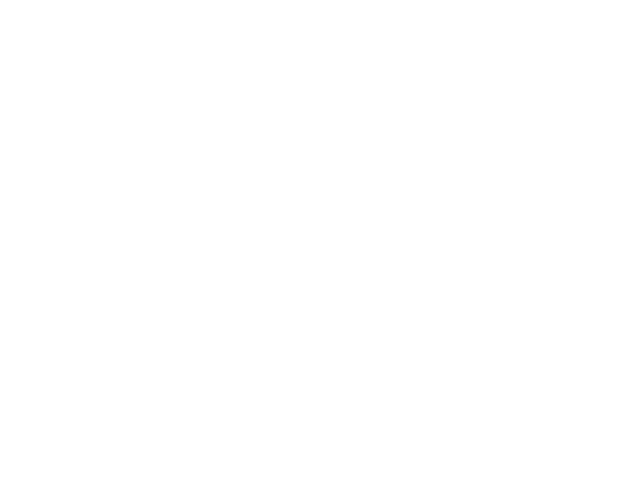

In [24]:
%matplotlib notebook

points = randomPoints(-100,100,100)
visualiser = Scan_visualiser()
jarvis(points, visualiser)
scenes = visualiser.get_scenes()
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


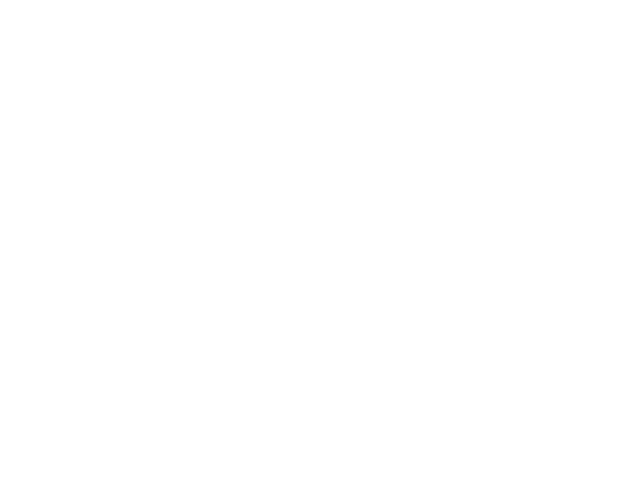

In [25]:
%matplotlib notebook
visualiser = Scan_visualiser()
jarvis(circle, visualiser)
scenes = visualiser.scenes
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


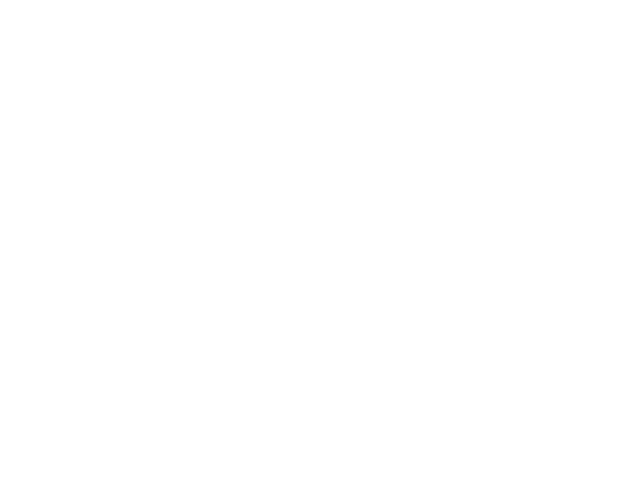

In [26]:
%matplotlib notebook
visualiser = Scan_visualiser()
rectangle = randomPointsRectangle((-10,-10),(10,-10),(-10,10),(10,10),100)
jarvis(rectangle, visualiser)
scenes = visualiser.scenes
plot = Plot(scenes)
plot.draw()

In [34]:
%matplotlib notebook
visualiser = Scan_visualiser()
square = randomPointsSquare((0,0),(10,0),(0,10),(10,10),25,20)
jarvis(square, visualiser)
scenes = visualiser.scenes
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>

## Czas pracy programu

In [28]:
import time
def measure_time():
    
    visualiser = Scan_visualiser()

    start = time.time()
    graham(points,visualiser)
    print("Graham for points: %s seconds" % (time.time() - start))

    start = time.time()
    graham(circle,visualiser)
    print("Graham for circle: %s seconds" % (time.time() - start))

    start = time.time()
    graham(rectangle,visualiser)
    print("Graham for rectangle: %s seconds" % (time.time() - start))

    start = time.time()
    graham(square,visualiser)
    print("Graham for square: %s seconds" % (time.time() - start))
    
    print("")
    
    start_time = time.time()
    jarvis(points,visualiser)
    print("Jarvis for points: %s seconds" % (time.time() - start_time))
    
    start_time = time.time()
    jarvis(circle,visualiser)
    print("Jarvis for circle: %s seconds" % (time.time() - start_time))
    
    start_time = time.time()
    jarvis(rectangle,visualiser)
    print("Jarvis for rectangle: %s seconds" % (time.time() - start_time))
    
    start_time = time.time()
    jarvis(square,visualiser)
    print("Jarvis for square: %s seconds" % (time.time() - start_time))
    
    
    
def measure_graham():
    n = 1000
    A = randomPoints(0,1000,n)
    B = randomPointsCircle(100,n,(0,0))
    C = randomPointsRectangle((-100,-100),(100,-100),(-100,100),(100,100),n)
    D = randomPointsSquare((-100,-100),(100,-100),(-100,100),(100,100),n//2,n//2)
    
    
    start = time.time()
    graham(A,visualiser)
    print("n=1000")
    print("Graham for A: %s seconds" % (time.time() - start))
    start = time.time()
    graham(B,visualiser)
    print("Graham for B: %s seconds" % (time.time() - start))
    start = time.time()
    graham(C,visualiser)
    print("Graham for C: %s seconds" % (time.time() - start))
    start = time.time()
    graham(D,visualiser)
    print("Graham for D: %s seconds" % (time.time() - start))
    print("")
    
    n = 10000
    A = randomPoints(0,1000,n)
    B = randomPointsCircle(100,n,(0,0))
    C = randomPointsRectangle((-100,-100),(100,-100),(-100,100),(100,100),n)
    D = randomPointsSquare((-100,-100),(100,-100),(-100,100),(100,100),n//2,n//2)

    start = time.time()
    graham(A,visualiser)
    print("n=10000")
    print("Graham for A: %s seconds" % (time.time() - start))
    start = time.time()
    graham(B,visualiser)
    print("Graham for B: %s seconds" % (time.time() - start))
    start = time.time()
    graham(C,visualiser)
    print("Graham for C: %s seconds" % (time.time() - start))
    start = time.time()
    graham(D,visualiser)
    print("Graham for D: %s seconds" % (time.time() - start))
    print("")
    
    
    n = 50000
    A = randomPoints(0,1000,n)
    B = randomPointsCircle(100,n,(0,0))
    C = randomPointsRectangle((-100,-100),(100,-100),(-100,100),(100,100),n)
    D = randomPointsSquare((-100,-100),(100,-100),(-100,100),(100,100),n//2,n//2)

    start = time.time()
    graham(A,visualiser)
    print("n=50000")
    print("Graham for A: %s seconds" % (time.time() - start))
    start = time.time()
    graham(B,visualiser)
    print("Graham for B: %s seconds" % (time.time() - start))
    start = time.time()
    graham(C,visualiser)
    print("Graham for C: %s seconds" % (time.time() - start))
    start = time.time()
    graham(D,visualiser)
    print("Graham for D: %s seconds" % (time.time() - start))
    print("")

    
def measure_jarvis():
    n = 1000
    A = randomPoints(0,1000,n)
    B = randomPointsCircle(100,n,(0,0))
    C = randomPointsRectangle((-100,-100),(100,-100),(-100,100),(100,100),n)
    D = randomPointsSquare((-100,-100),(100,-100),(-100,100),(100,100),n//2,n//2)

    
    start = time.time()
    jarvis(A,visualiser)
    print("n=1000")
    print("Jarvis for A: %s seconds" % (time.time() - start))
    start = time.time()
    jarvis(B,visualiser)
    print("Jarvis for B: %s seconds" % (time.time() - start))
    start = time.time()
    jarvis(C,visualiser)
    print("Jarvis for C: %s seconds" % (time.time() - start))
    start = time.time()
    jarvis(D,visualiser)
    print("Jarvis for D: %s seconds" % (time.time() - start))
    print("")
    
    n = 2000
    A = randomPoints(0,1000,n)
    B = randomPointsCircle(100,n,(0,0))
    C = randomPointsRectangle((-100,-100),(100,-100),(-100,100),(100,100),n)
    D = randomPointsSquare((-100,-100),(100,-100),(-100,100),(100,100),n//2,n//2)

    
    start = time.time()
    jarvis(A,visualiser)
    print("n=2000")
    print("Jarvis for A: %s seconds" % (time.time() - start))
    start = time.time()
    jarvis(B,visualiser)
    print("Jarvis for B: %s seconds" % (time.time() - start))
    start = time.time()
    jarvis(C,visualiser)
    print("Jarvis for C: %s seconds" % (time.time() - start))
    start = time.time()
    jarvis(D,visualiser)
    print("Jarvis for D: %s seconds" % (time.time() - start))
    print("")
    
    
    n = 3000
    A = randomPoints(0,1000,n)
    B = randomPointsCircle(100,n,(0,0))
    C = randomPointsRectangle((-100,-100),(100,-100),(-100,100),(100,100),n)
    D = randomPointsSquare((-100,-100),(100,-100),(-100,100),(100,100),n//2,n//2)

    
    start = time.time()
    jarvis(A,visualiser)
    print("n=3000")
    print("Jarvis for A: %s seconds" % (time.time() - start))
    start = time.time()
    jarvis(B,visualiser)
    print("Jarvis for B: %s seconds" % (time.time() - start))
    start = time.time()
    jarvis(C,visualiser)
    print("Jarvis for C: %s seconds" % (time.time() - start))
    start = time.time()
    jarvis(D,visualiser)
    print("Jarvis for D: %s seconds" % (time.time() - start))
    print("")
    
    
    

In [29]:
measure_time()

Graham for points: 0.0009343624114990234 seconds
Graham for circle: 0.000133514404296875 seconds
Graham for rectangle: 0.0004382133483886719 seconds
Graham for square: 0.0003523826599121094 seconds

Jarvis for points: 0.0008647441864013672 seconds
Jarvis for circle: 0.004395961761474609 seconds
Jarvis for rectangle: 0.0006835460662841797 seconds
Jarvis for square: 0.0004601478576660156 seconds


In [30]:
measure_graham()

n=1000
Graham for A: 0.007787942886352539 seconds
Graham for B: 0.0014770030975341797 seconds
Graham for C: 0.03603172302246094 seconds
Graham for D: 0.01198887825012207 seconds

n=10000
Graham for A: 0.2594127655029297 seconds
Graham for B: 0.017065763473510742 seconds
Graham for C: 0.14221644401550293 seconds
Graham for D: 0.3410186767578125 seconds

n=50000
Graham for A: 1.2405292987823486 seconds
Graham for B: 3.7539265155792236 seconds
Graham for C: 1.1489088535308838 seconds
Graham for D: 0.5878174304962158 seconds



In [31]:
measure_jarvis()

n=1000
Jarvis for A: 0.01679825782775879 seconds
Jarvis for B: 0.5673098564147949 seconds
Jarvis for C: 0.00778651237487793 seconds
Jarvis for D: 0.012078285217285156 seconds

n=2000
Jarvis for A: 0.03712344169616699 seconds
Jarvis for B: 3.286931037902832 seconds
Jarvis for C: 0.015614509582519531 seconds
Jarvis for D: 0.0242307186126709 seconds

n=3000
Jarvis for A: 0.053073883056640625 seconds
Jarvis for B: 7.745103597640991 seconds
Jarvis for C: 0.024401426315307617 seconds
Jarvis for D: 0.03760695457458496 seconds

